# **<span style="color:red">Imports</span>**

In [1]:
# Handy arrays
import numpy as np

# FFTs
import scipy.fft as fft
import scipy.fftpack as fftp

# Blind deconvolution
import skimage

# Custom modules
import lib.utils.utils as Utils
import lib.utils.plotting as Plotting
import lib.utils.otf as OTF
import lib.methods.distortion as Distortion
import lib.methods.tikhonov as TikhonovMethod
import lib.methods.bispectral as BispectralMethod
import lib.scripts as Scripts
import lib.vkr.sample_presets as SamplePresets

# <span style="color:red">**Reconstruction of real samples**</span>

## <span style="color:orange">**Samples init**</span>

### <span>**Samples**</span>

In [ ]:
sample_preset_1 = SamplePresets.SamplePreset('Samples/VKR/1/IMG_8213.JPG', 'Samples/VKR/1/IMG_8212.JPG',
                                             None, 'Results_(VKR)/Sample_1/',
                                             1e-2, 0.003, 0.6,
                                             10.4,
                                             200,
                                             1e-5,
                                             3e-3, 0.1,
                                             0.04)

In [ ]:
sample_preset_2 = SamplePresets.SamplePreset('Samples/VKR/2/DSC08017.JPG', 'Samples/VKR/2/DSC08011.JPG',
                                             (slice(0, 2048), slice(1775, 3823)), 'Results_(VKR)/Sample_2/',
                                             1e-3, 0.003, 0.5,
                                             7.4,
                                             50,
                                             5e-5,
                                             5e-3, 0.1,
                                             0.04)

In [13]:
# Preset choice
selected_sample = sample_preset_2

### <span>**Image**</span>

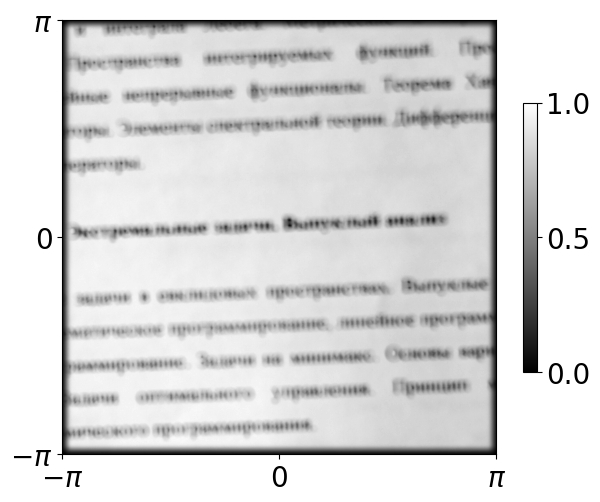

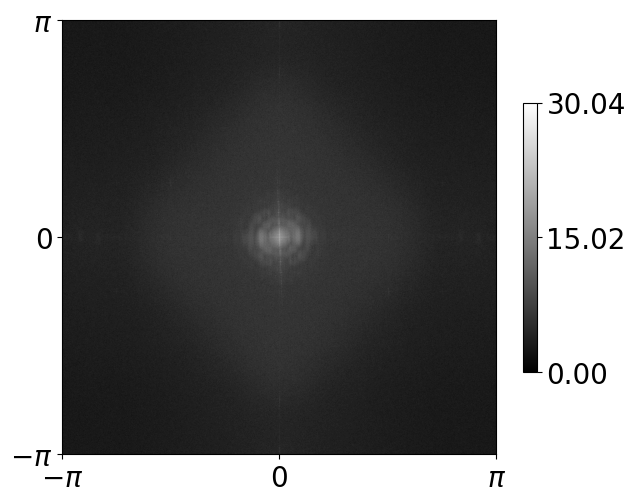

In [4]:
image_blurred = Utils.image_load(selected_sample.filepath, selected_sample.crop_slice)
window_func = Utils.create_super_gauss(image_blurred.shape, 10.8/11, 40, mode='square')
image_blurred *= Distortion.image_distortion(window_func, selected_sample.defocus_param)
image_blurred = Utils.image_normalize(image_blurred)
Plotting.plot_image(image_blurred)
Plotting.plot_spectrum(image_blurred)

In [6]:
Utils.image_save(Utils.image_crop_corners(image_blurred), selected_sample.sample_folder + '2, observed.png')

## <span style="color:orange">**Restoration**</span>

### <span>**Defocus parameter estimation**</span>

Min defocus param is:  7.4
Other known mins:
[ 4.1  7.4 10.7 11.7 13.6 15.8 16.2 17.4 17.6 17.9 18.2 19.2 19.6]


7.4

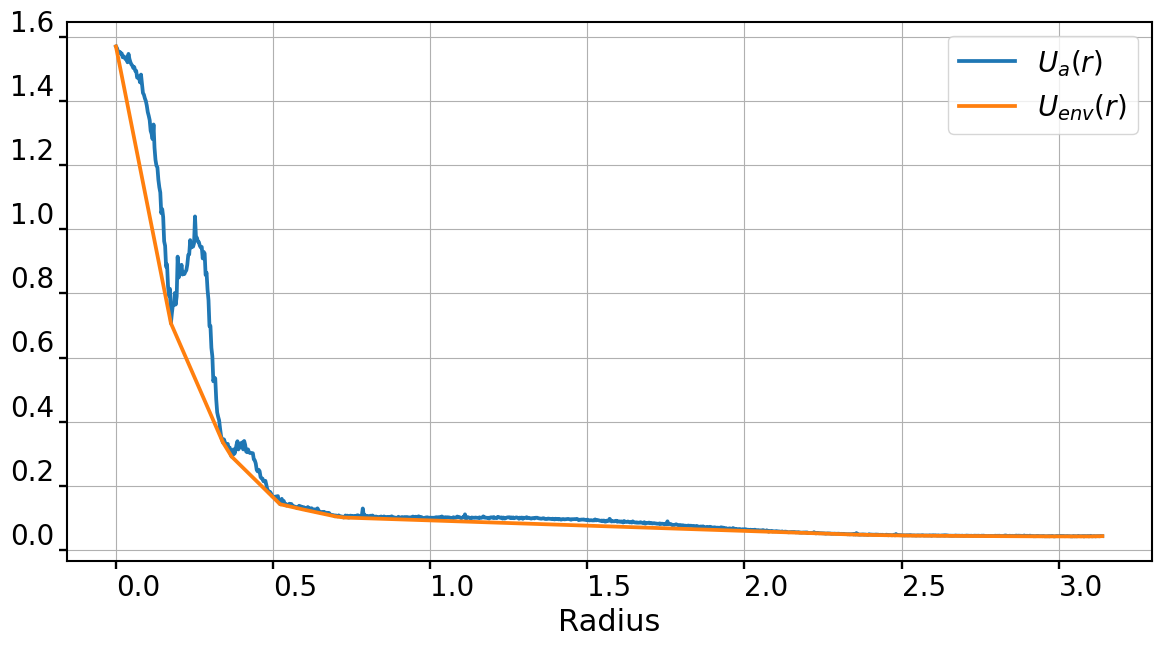

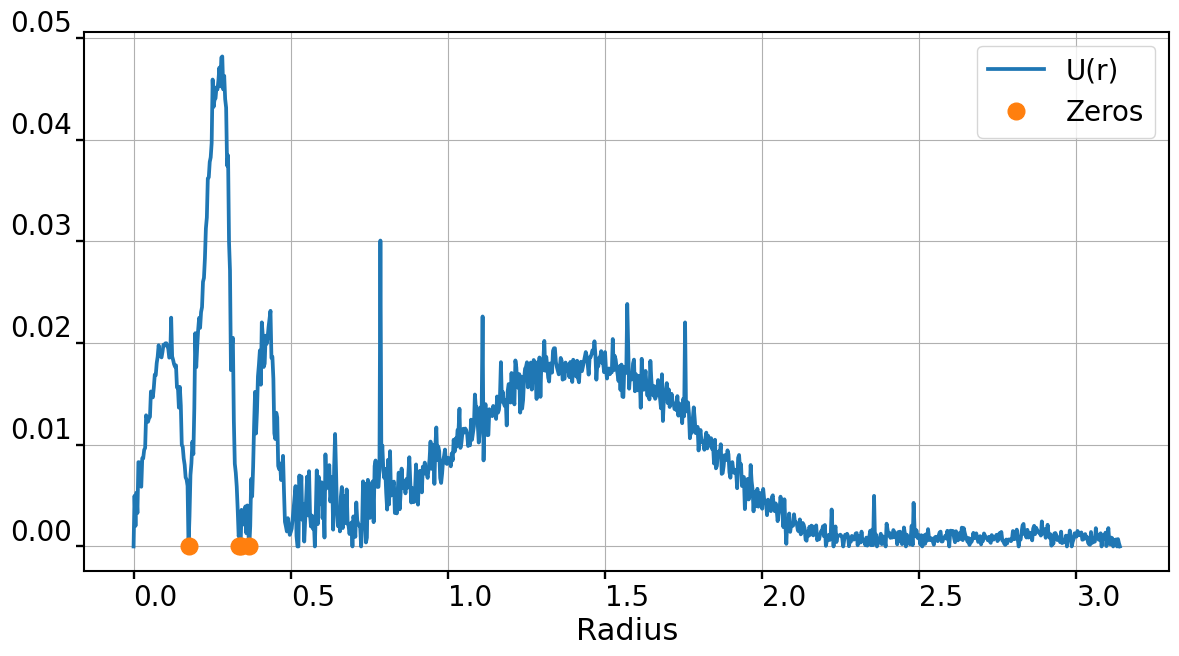

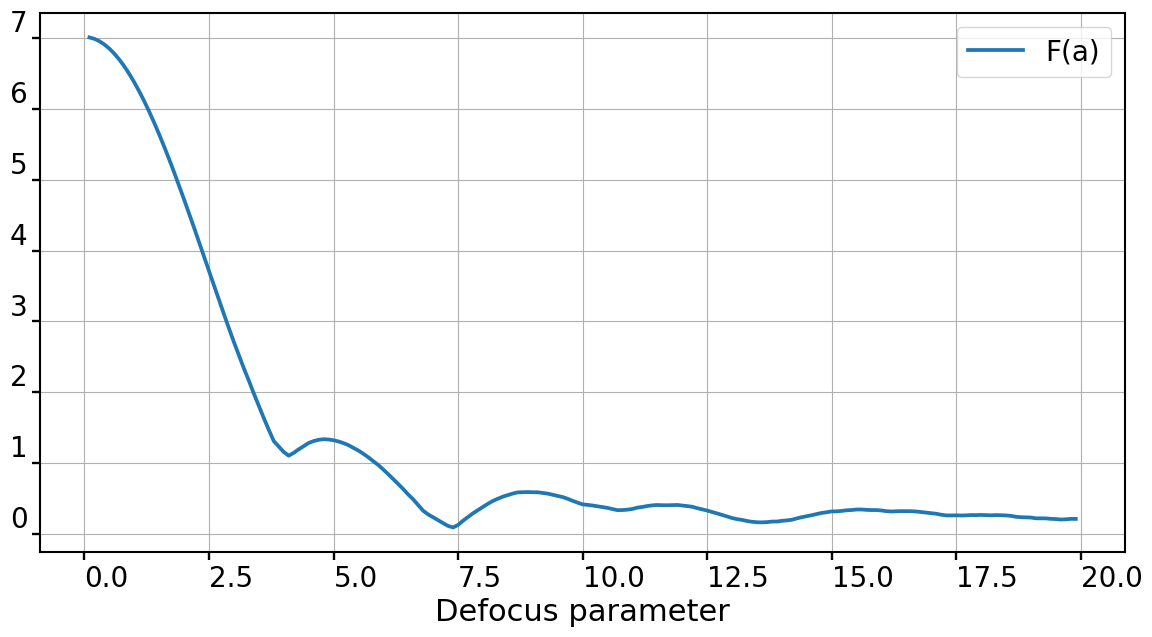

In [9]:
Scripts.estimate_defocus_param(image_blurred, selected_sample.average_angled_spectrum_k, selected_sample.average_angled_spectrum_b,
                               selected_sample.zeros_range_ratio, plot_folder=selected_sample.sample_folder)

### <span>**OTF preparation**</span>

In [5]:
psf = OTF.create_psf(image_blurred.shape, selected_sample.defocus_param)
otf = OTF.psf2otf(psf)
psf /= np.max(psf)

### <span>**Image restoration**</span>

Blind deconvolution

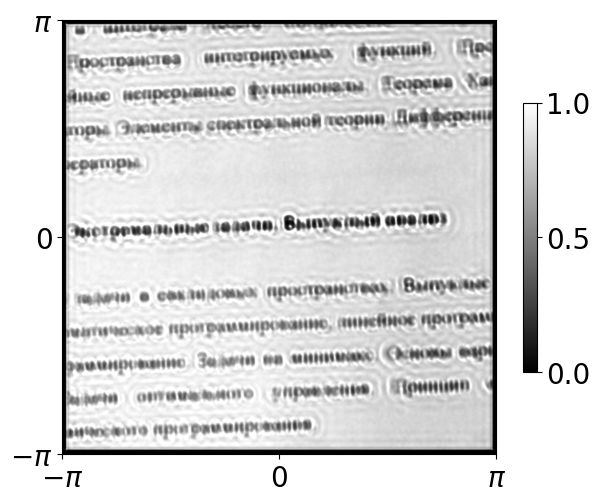

In [11]:
image_restored_blind1 = Utils.image_normalize(skimage.restoration.richardson_lucy(image_blurred,
                                                                                 fftp.fftshift(psf>0.1),
                                                                                 num_iter=selected_sample.deconv_iters))
Plotting.plot_image(image_restored_blind1)

In [11]:
Utils.image_save(Utils.image_crop_corners(image_restored_blind1, ratio=selected_sample.crop_ratio), selected_sample.sample_folder + '8, blind deconv(1).png')

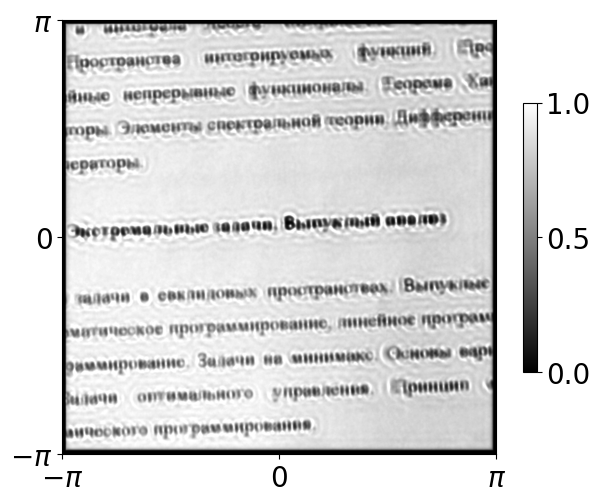

In [12]:
image_restored_blind2 = Utils.image_normalize(skimage.restoration.richardson_lucy(image_blurred,
                                                                                 fftp.fftshift(psf),
                                                                                 num_iter=selected_sample.deconv_iters))
Plotting.plot_image(image_restored_blind2)

In [11]:
Utils.image_save(Utils.image_crop_corners(image_restored_blind2), selected_sample.sample_folder + '8, blind deconv(2).png')

Both methods at best parameters

In [14]:
image_restored_bisp = BispectralMethod.bispectral_method(image_blurred, otf, selected_sample.bispectral_alpha)

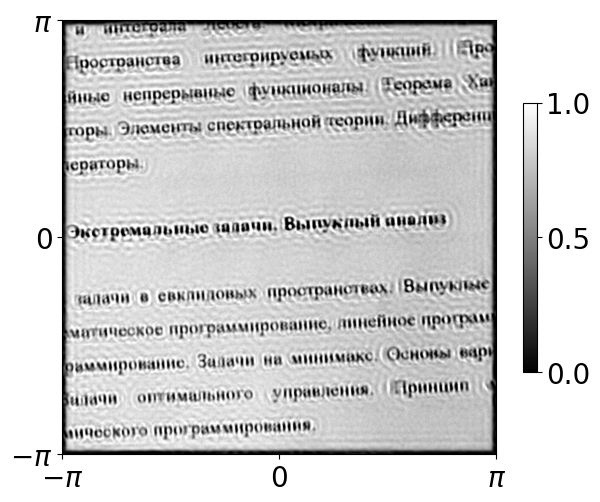

In [23]:
image_restored_bisp = np.roll(image_restored_bisp, (0, 5), axis=(1,0))
Plotting.plot_image(image_restored_bisp)

In [24]:
Utils.image_save(Utils.image_crop_corners(image_restored_bisp), selected_sample.sample_folder + '6, bisp.png')

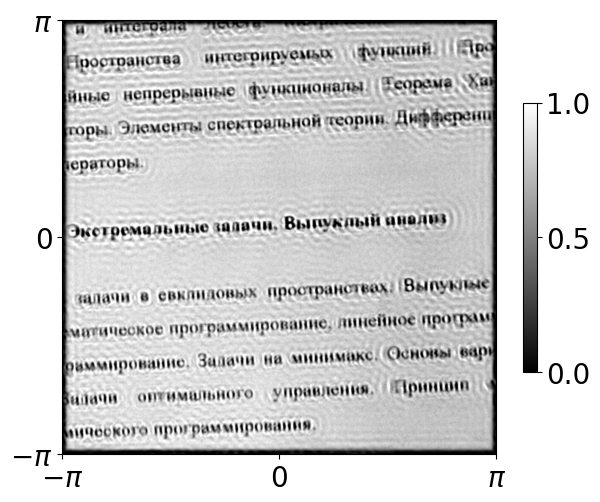

In [8]:
image_restored_tich = TikhonovMethod.tikhonov_regularization_method(image_blurred, otf, selected_sample.tikhonov_alpha, selected_sample.tikhonov_r)
Plotting.plot_image(image_restored_tich)

In [33]:
Utils.image_save(Utils.image_crop_corners(image_restored_tich), selected_sample.sample_folder + '7, tich.png')

### <span>**Metrics**</span>

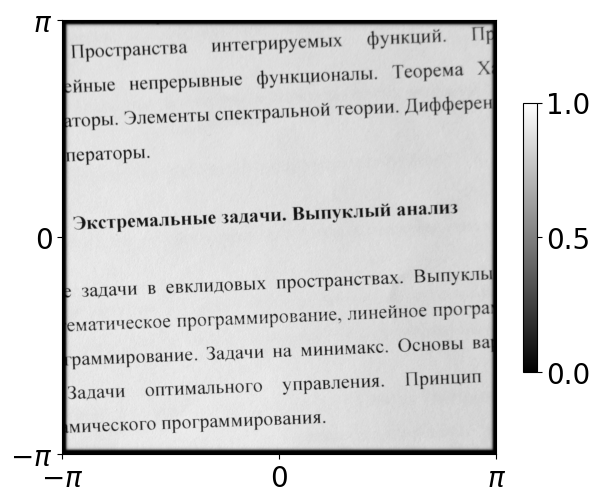

In [34]:
image_original = Utils.image_load(selected_sample.filepath_orig, selected_sample.crop_slice) * window_func
image_original = Utils.image_normalize(image_original)
Plotting.plot_image(image_original)

In [33]:
Utils.image_save(Utils.image_crop_corners(image_original), selected_sample.sample_folder + '1, original.png')

In [35]:
Scripts.compair_results(selected_sample.sample_folder)

Blind deconvolution 1 metrics:
MSE 0.053407
SSIM 0.600879
Blind deconvolution 2 metrics:
MSE 0.053548
SSIM 0.603479
Bispectral method metrics:
MSE 0.074077
SSIM 0.414537
Tikhonov method metrics:
MSE 0.062422
SSIM 0.498320
